In [97]:
import pandas as pd
import numpy as np
np.random.seed(123)  # for reproducibility
 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, LeakyReLU, PReLU
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf

from scipy.ndimage import rotate

from random import uniform
from numpy.random import choice

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [4]:
# read in data
training = pd.read_csv("all/training.csv")
training.shape

(7049, 31)

In [5]:
training.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

# Data Validation 
## Check missing distributions

In [4]:
# check missing distribution
check1 = pd.isnull(training)
check2 = check1.groupby(list(check1.columns[:-1]))['Image'].value_counts().to_dict()

In [5]:
check3 = list(check1.groupby(list(check1.columns[:-1]))['Image'].count())
for i in range(len(check3)):
    print(i, ":", check3[i])

0 : 2140
1 : 13
2 : 3
3 : 4
4 : 3
5 : 1
6 : 3
7 : 26
8 : 1
9 : 1
10 : 2
11 : 31
12 : 1
13 : 2
14 : 6
15 : 1
16 : 2
17 : 1
18 : 3
19 : 1
20 : 1
21 : 2
22 : 1
23 : 1
24 : 1
25 : 4
26 : 2
27 : 1
28 : 1
29 : 1
30 : 2
31 : 1
32 : 3
33 : 2
34 : 4755
35 : 10
36 : 1
37 : 3
38 : 1
39 : 1
40 : 1
41 : 1
42 : 1
43 : 1
44 : 1
45 : 1
46 : 1
47 : 1
48 : 1
49 : 1


In [6]:
case = 6
for i in range(len(list(check2.items())[case][0])):
    print(i, list(check2.items())[case][0][i], ":", list(check1.columns)[i])

0 False : left_eye_center_x
1 False : left_eye_center_y
2 False : right_eye_center_x
3 False : right_eye_center_y
4 False : left_eye_inner_corner_x
5 False : left_eye_inner_corner_y
6 False : left_eye_outer_corner_x
7 False : left_eye_outer_corner_y
8 False : right_eye_inner_corner_x
9 False : right_eye_inner_corner_y
10 False : right_eye_outer_corner_x
11 False : right_eye_outer_corner_y
12 False : left_eyebrow_inner_end_x
13 False : left_eyebrow_inner_end_y
14 False : left_eyebrow_outer_end_x
15 False : left_eyebrow_outer_end_y
16 False : right_eyebrow_inner_end_x
17 False : right_eyebrow_inner_end_y
18 False : right_eyebrow_outer_end_x
19 False : right_eyebrow_outer_end_y
20 False : nose_tip_x
21 False : nose_tip_y
22 True : mouth_left_corner_x
23 True : mouth_left_corner_y
24 True : mouth_right_corner_x
25 True : mouth_right_corner_y
26 True : mouth_center_top_lip_x
27 True : mouth_center_top_lip_y
28 True : mouth_center_bottom_lip_x
29 True : mouth_center_bottom_lip_y
30 False : I

## Data Validation Findings

**2140 obs are non-missing (case 0)**

**4755 obs only have 8 non-missing key points (case 34)**
* False : left_eye_center_x
* False : left_eye_center_y
* False : right_eye_center_x
* False : right_eye_center_y
* False : nose_tip_x
* False : nose_tip_y
* False : mouth_center_bottom_lip_x
* False : mouth_center_bottom_lip_y
    
**31 obs only missing left_eyebrow_outer_end (case 11)**
* True : left_eyebrow_outer_end_x
* True : left_eyebrow_outer_end_y

**26 obs only missing right_eyebrow_outer_end (case 7)**
* True : right_eyebrow_outer_end_x
* True : right_eyebrow_outer_end_y

**13 obs only missing mouth_center_bottom_lip (case 1)**
* True : mouth_center_bottom_lip_x
* True : mouth_center_bottom_lip_y

**10 obs only have the following non-missing key points (case 35)**
* False : left_eye_center_x
* False : left_eye_center_y
* False : right_eye_center_x
* False : right_eye_center_y
* False : nose_tip_x
* False : nose_tip_y

**74 remaining obs have various missing points**

## Data Validation Decisions

Build two models, each to predict the following key points:

**Model 1:**
number of non-missing observations: 7000
* left_eye_center
* right_eye_center
* nose_tip
* mouth_center_bottom_lip

**Model 2:**
number of non-missing observations: 2155
* left_eye_inner_corner
* left_eye_outer_corner
* right_eye_inner_corner
* right_eye_outer_corner

* left_eyebrow_inner_end
* left_eyebrow_outer_end
* right_eyebrow_inner_end
* right_eyebrow_outer_end

* mouth_left_corner
* mouth_right_corner
* mouth_center_top_lip

In [10]:
# how many data points would we have?
points = [0, 1, 2, 3, 20, 21, 28, 29]
model = training.iloc[:, points]
print(model.shape)
model_nonmiss = model[~np.isnan(model).any(axis=1)]
print(model_nonmiss.shape)

(7049, 8)
(7000, 8)


In [11]:
points = list(range(4,20)) + list(range(22,28))
model = training.iloc[:, points]
print(model.shape)
model_nonmiss = model[~np.isnan(model).any(axis=1)]
print(model_nonmiss.shape)

(7049, 22)
(2155, 22)


# Data Preprocessing
## Split training and validation

In [8]:
# shuffle dataset
np.random.seed(666)
shuffle = np.random.permutation(np.arange(training.shape[0]))
training2 = training.iloc[shuffle].reset_index(drop=True)

# split out image values
image = []
for i in range(training2.shape[0]):
    img = training2['Image'][i].split(' ')
    img = ['0' if j == '' else j for j in img]
    image.append(img)

In [9]:
# create training and validation set (80/20 split)
X = np.array(image, dtype = 'float')
X_train, X_val = X[:5640], X[5640:]
print(X_train.shape, X_val.shape)

# create training and validation labels (80/20 split)
labels = training2.drop('Image', axis=1)
y = np.array(labels, dtype = 'float')
y_train, y_val = y[:5640], y[5640:]
print(y_train.shape, y_val.shape)

(5640, 9216) (1409, 9216)
(5640, 30) (1409, 30)


In [10]:
# save data
np.save('X.npy', X)
np.save('y.npy', y)

## Apply transformations

### 1. Mirroring

In [5]:
# define mirror functions
def mirror_X(input_X):
    return input_X.reshape(-1,96,96)[:, :, list(range(95, -1, -1))].reshape(-1, 96*96)
    
def mirror_y(input_y, n_point):
    output_y = input_y.copy()
    # y coordinate stays the same, x coordinate is 96-x
    output_y[:,list(range(0,n_point-1,2))] = 95 - input_y[:,list(range(0,n_point-1,2))]
    return output_y

In [9]:
# transform
X_train_mirror = mirror_X(X_train)
y_train_mirror = mirror_y(y_train, 30)
# X_val_mirror = mirror_X(X_val)
# y_val_mirror = mirror_y(y_val, 30)

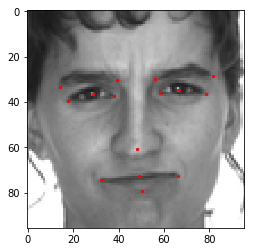

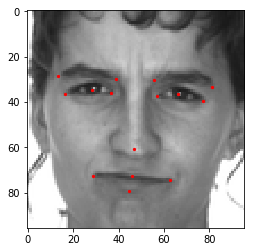

In [10]:
# check image
i=13
plt.imshow(X_train[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train[i, range(0, 30, 2)], y_train[i, range(1, 30, 2)], s=5, color='r')
plt.show()

plt.imshow(X_train_mirror[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train_mirror[i, range(0, 30, 2)], y_train_mirror[i, range(1, 30, 2)], s=5, color='r')
plt.show()

### 2. Rotating

In [6]:
# mirror function to transform X
def rotate_X(input_X, degree):
    
    # create an array of the same size
    output_X = np.zeros((input_X.shape), dtype=np.float64)
    
    # for each image, use sklearn's rotate function to rotate image
    # this somehow changes pixel values, cap value between 0 and 255
    for i in range(output_X.shape[0]):
        output_X[i] = np.clip(rotate(input_X.reshape(-1,96,96)[i], degree, reshape=False, mode='constant', \
                                       cval=150).reshape(96*96), 0, 255)  
    return output_X
        
    
# mirror function to transform y
def rotate_y(input_y, degree, n_point):
    
    # create an array of same size
    output_y = np.zeros((input_y.shape), dtype=np.float64)
    
    # define rotation angle and center of rotation
    theta = np.radians(degree)
    center_x = 95/2
    center_y = 95/2

    for i in range(output_y.shape[0]):
        
        # obtain x and y coordinates from dataset
        x = input_y[i][np.arange(0,n_point-1,2)]
        y = input_y[i][np.arange(1,n_point,2)]
        
        # use rotation matrix to rotate coordinates around center
        x2 = np.cos(theta) * (x - center_x) + np.sin(theta) * (y - center_y) + center_x
        y2 = -np.sin(theta) * (x - center_x) + np.cos(theta) * (y - center_y) + center_y
        
        # put x and y back in original shape
        output_y[i] = np.vstack((x2,y2)).transpose().flatten()
        
    return output_y

In [12]:
# transform
X_train_rotate = rotate_X(X_train, -15)
y_train_rotate = rotate_y(y_train, -15, 30)
# X_val_rotate = rotate_X(X_train, -15)
# y_val_rotate = rotate_y(y_train, -15)

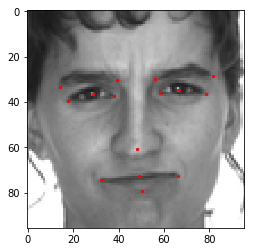

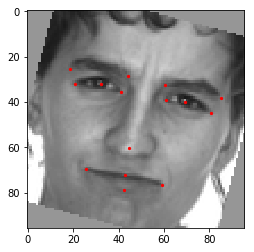

In [13]:
# check image
i=13

plt.imshow(X_train[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train[i, range(0, 30, 2)], y_train[i, range(1, 30, 2)], s=5, color='r')
plt.show()

plt.imshow(X_train_rotate[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train_rotate[i, range(0, 30, 2)], y_train_rotate[i, range(1, 30, 2)], s=5, color='r')
plt.show()

### 3. Contrast Reduction

In [7]:
# define function - only need to transform X
def reduce_contrast(input_X, weight):
    return (weight * input_X) + (1 - weight) * input_X.mean()

In [15]:
# transform
X_train_contrast = reduce_contrast(X_train, 0.7)
# X_val_contrast = reduce_contrast(X_val, 0.7)

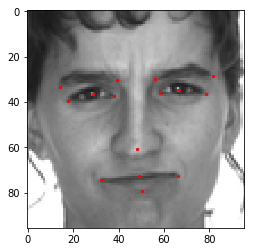

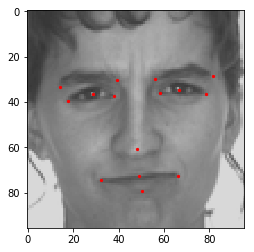

In [16]:
# check image
i=13

plt.imshow(X_train[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train[i, range(0, 30, 2)], y_train[i, range(1, 30, 2)], s=5, color='r')
plt.show()

plt.imshow(X_train_contrast[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train[i, range(0, 30, 2)], y_train[i, range(1, 30, 2)], s=5, color='r')
plt.show()

# Modeling

## Test Data Augmentation
### 0. Baseline

In [30]:
# test on model 1 with 8 points, prep data

# filter labels on only those 8 points
points = [0, 1, 2, 3, 20, 21, 28, 29]
y_train_model1 = y_train[:, points]
y_val_model1 = y_val[:, points]

# get index of non-missing labels
index_train = ~np.isnan(y_train_model1).any(axis=1)
index_val = ~np.isnan(y_val_model1).any(axis=1)

# filter out missing labels on training and validation data
X_train_nm = X_train[index_train]
y_train_nm = y_train_model1[index_train]
X_val_nm = X_val[index_val]
y_val_nm = y_val_model1[index_val]

print(X_train_nm.shape)
print(y_train_nm.shape)
print(X_val_nm.shape)
print(y_val_nm.shape)

(5603, 9216)
(5603, 8)
(1397, 9216)
(1397, 8)


In [39]:
# define simple CNN model with 3 conv layers and 2 fully connected layers
def SimpleModel_1(weights_path=None):
    model = Sequential()
    model.add(Conv2D(8, (5, 5), strides=(1,1), activation='relu', input_shape=(96,96,1), \
                     data_format='channels_last'))
    model.add(Conv2D(4, (3, 3), strides=(1,1), activation='relu'))
    model.add(Conv2D(2, (3, 3), strides=(1,1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(8))

    if weights_path:
        model.load_weights(weights_path)

    return model

# define RMSE
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [120]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1 = model.fit(X_train_nm.reshape(-1,96,96,1), y_train_nm, \
                                        epochs=50, shuffle=False, batch_size=50, \
                                        validation_data=(X_val_nm.reshape(-1,96,96,1), y_val_nm), \
                                        verbose=2)

Train on 5603 samples, validate on 1397 samples
Epoch 1/50
 - 3s - loss: 522.1793 - rmse: 19.9870 - mean_absolute_error: 16.0488 - mean_absolute_percentage_error: 31.5599 - val_loss: 128.7805 - val_rmse: 11.3095 - val_mean_absolute_error: 8.6636 - val_mean_absolute_percentage_error: 17.6493
Epoch 2/50
 - 2s - loss: 120.9847 - rmse: 10.9103 - mean_absolute_error: 8.4070 - mean_absolute_percentage_error: 16.6855 - val_loss: 125.4605 - val_rmse: 11.1621 - val_mean_absolute_error: 8.5527 - val_mean_absolute_percentage_error: 16.9075
Epoch 3/50
 - 2s - loss: 91.2448 - rmse: 9.4781 - mean_absolute_error: 7.2708 - mean_absolute_percentage_error: 14.5094 - val_loss: 102.6195 - val_rmse: 10.0920 - val_mean_absolute_error: 7.6792 - val_mean_absolute_percentage_error: 15.5870
Epoch 4/50
 - 2s - loss: 71.4195 - rmse: 8.3822 - mean_absolute_error: 6.3856 - mean_absolute_percentage_error: 12.7547 - val_loss: 162.6611 - val_rmse: 12.7254 - val_mean_absolute_error: 10.1999 - val_mean_absolute_percenta

Epoch 36/50
 - 2s - loss: 3.8890 - rmse: 1.8878 - mean_absolute_error: 1.3552 - mean_absolute_percentage_error: 2.8919 - val_loss: 22.5022 - val_rmse: 4.7090 - val_mean_absolute_error: 3.4397 - val_mean_absolute_percentage_error: 7.1448
Epoch 37/50
 - 2s - loss: 4.0520 - rmse: 1.9360 - mean_absolute_error: 1.3997 - mean_absolute_percentage_error: 2.9516 - val_loss: 20.3714 - val_rmse: 4.4517 - val_mean_absolute_error: 3.1050 - val_mean_absolute_percentage_error: 6.6977
Epoch 38/50
 - 2s - loss: 3.5796 - rmse: 1.8190 - mean_absolute_error: 1.3108 - mean_absolute_percentage_error: 2.7992 - val_loss: 27.1653 - val_rmse: 5.1887 - val_mean_absolute_error: 3.9989 - val_mean_absolute_percentage_error: 8.2399
Epoch 39/50
 - 2s - loss: 3.9855 - rmse: 1.9111 - mean_absolute_error: 1.3878 - mean_absolute_percentage_error: 2.9316 - val_loss: 22.0930 - val_rmse: 4.6542 - val_mean_absolute_error: 3.3998 - val_mean_absolute_percentage_error: 7.2258
Epoch 40/50
 - 2s - loss: 4.7408 - rmse: 2.0400 - me

4.031752987768109


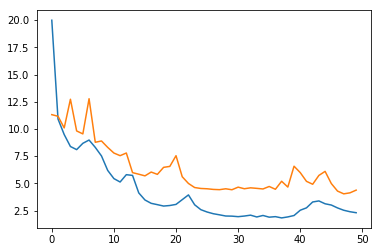

In [121]:
# plot metrics
print(min(history_SimpleModel_1.history['val_rmse']))
plt.plot(history_SimpleModel_1.history['rmse'])
plt.plot(history_SimpleModel_1.history['val_rmse'])
plt.show()

### 1. Test mirroring alone

In [122]:
# test on model 1 with 8 points, prep data
X_train_model = np.concatenate((X_train_nm, mirror_X(X_train_nm)), axis=0).reshape(-1,96,96,1)
y_train_model = np.concatenate((y_train_nm, mirror_y(y_train_nm, 8)), axis=0)
# X_val_model = np.concatenate((X_val_nm, mirror_X(X_val_nm)), axis=0).reshape(-1,96,96,1)
# y_val_model = np.concatenate((y_val_nm, mirror_y(y_val_nm, 8)), axis=0)
X_val_model = X_val_nm.reshape(-1,96,96,1)
y_val_model = y_val_nm

print(X_train_model.shape)
print(y_train_model.shape)
print(X_val_model.shape)
print(y_val_model.shape)

(11206, 96, 96, 1)
(11206, 8)
(1397, 96, 96, 1)
(1397, 8)


In [123]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1_mirror = model.fit(X_train_model, y_train_model, \
                                        epochs=50, shuffle=False, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

Train on 11206 samples, validate on 1397 samples
Epoch 1/50
 - 5s - loss: 273.5224 - rmse: 14.8053 - mean_absolute_error: 11.6688 - mean_absolute_percentage_error: 23.4597 - val_loss: 455.1717 - val_rmse: 21.3223 - val_mean_absolute_error: 15.3563 - val_mean_absolute_percentage_error: 35.6004
Epoch 2/50
 - 3s - loss: 69.3265 - rmse: 7.8038 - mean_absolute_error: 5.9058 - mean_absolute_percentage_error: 12.2704 - val_loss: 349.2299 - val_rmse: 18.6860 - val_mean_absolute_error: 11.8040 - val_mean_absolute_percentage_error: 27.6689
Epoch 3/50
 - 3s - loss: 36.4517 - rmse: 5.3274 - mean_absolute_error: 3.8085 - mean_absolute_percentage_error: 8.3630 - val_loss: 346.1308 - val_rmse: 18.6037 - val_mean_absolute_error: 11.4875 - val_mean_absolute_percentage_error: 27.1485
Epoch 4/50
 - 3s - loss: 36.4398 - rmse: 5.1547 - mean_absolute_error: 3.6598 - mean_absolute_percentage_error: 8.1076 - val_loss: 343.5860 - val_rmse: 18.5352 - val_mean_absolute_error: 11.3642 - val_mean_absolute_percenta

Epoch 35/50
 - 3s - loss: 106.1041 - rmse: 9.8887 - mean_absolute_error: 6.8356 - mean_absolute_percentage_error: 15.9924 - val_loss: 188.4402 - val_rmse: 13.7262 - val_mean_absolute_error: 8.9575 - val_mean_absolute_percentage_error: 21.0103
Epoch 36/50
 - 3s - loss: 105.4055 - rmse: 10.0195 - mean_absolute_error: 6.9001 - mean_absolute_percentage_error: 16.2028 - val_loss: 178.9032 - val_rmse: 13.3743 - val_mean_absolute_error: 8.7721 - val_mean_absolute_percentage_error: 20.5290
Epoch 37/50
 - 3s - loss: 83.4926 - rmse: 8.4875 - mean_absolute_error: 5.8832 - mean_absolute_percentage_error: 13.5213 - val_loss: 340.2989 - val_rmse: 18.4466 - val_mean_absolute_error: 11.3695 - val_mean_absolute_percentage_error: 26.8498
Epoch 38/50
 - 3s - loss: 100.3519 - rmse: 9.3484 - mean_absolute_error: 6.5009 - mean_absolute_percentage_error: 15.1664 - val_loss: 267.3402 - val_rmse: 16.3498 - val_mean_absolute_error: 10.3484 - val_mean_absolute_percentage_error: 24.4144
Epoch 39/50
 - 3s - loss: 

13.37427734628949


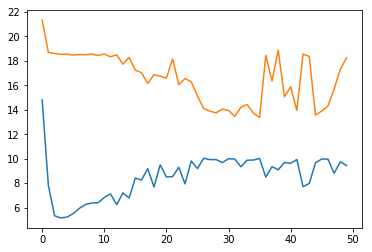

In [124]:
# plot metrics
print(min(history_SimpleModel_1_mirror.history['val_rmse']))
plt.plot(history_SimpleModel_1_mirror.history['rmse'])
plt.plot(history_SimpleModel_1_mirror.history['val_rmse'])
plt.show()

### 2. Test rotating alone

**5 degree**

In [110]:
# transform data
degree = -5
n_point = 8
X_train_model = np.concatenate((X_train_nm, rotate_X(X_train_nm, degree)), axis=0).reshape(-1,96,96,1)
y_train_model = np.concatenate((y_train_nm, rotate_y(y_train_nm, degree, n_point)), axis=0)
# X_val_model = np.concatenate((X_val_nm, rotate_X(X_val_nm, degree)), axis=0).reshape(-1,96,96,1)
# y_val_model = np.concatenate((y_val_nm, rotate_y(y_val_nm, degree, n_point)), axis=0)
X_val_model = X_val_nm.reshape(-1,96,96,1)
y_val_model = y_val_nm

print(X_train_model.shape)
print(y_train_model.shape)
print(X_val_model.shape)
print(y_val_model.shape)

(11206, 96, 96, 1)
(11206, 8)
(1397, 96, 96, 1)
(1397, 8)


In [111]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1_rotate_5 = model.fit(X_train_model, y_train_model, \
                                        epochs=50, shuffle=False, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

Train on 11206 samples, validate on 1397 samples
Epoch 1/50
 - 4s - loss: 390.2144 - rmse: 15.3813 - mean_absolute_error: 12.1723 - mean_absolute_percentage_error: 24.0590 - val_loss: 139.6264 - val_rmse: 11.7776 - val_mean_absolute_error: 9.0983 - val_mean_absolute_percentage_error: 18.2852
Epoch 2/50
 - 3s - loss: 107.3194 - rmse: 10.1385 - mean_absolute_error: 7.7952 - mean_absolute_percentage_error: 15.5001 - val_loss: 189.3531 - val_rmse: 13.7230 - val_mean_absolute_error: 10.8366 - val_mean_absolute_percentage_error: 21.6244
Epoch 3/50
 - 3s - loss: 100.2759 - rmse: 9.7050 - mean_absolute_error: 7.4690 - mean_absolute_percentage_error: 14.8715 - val_loss: 191.4343 - val_rmse: 13.7982 - val_mean_absolute_error: 10.8973 - val_mean_absolute_percentage_error: 21.7019
Epoch 4/50
 - 3s - loss: 88.8088 - rmse: 9.0955 - mean_absolute_error: 6.9812 - mean_absolute_percentage_error: 13.9006 - val_loss: 201.4398 - val_rmse: 14.1580 - val_mean_absolute_error: 11.2732 - val_mean_absolute_perc

Epoch 36/50
 - 3s - loss: 5.0461 - rmse: 2.2091 - mean_absolute_error: 1.6465 - mean_absolute_percentage_error: 3.5164 - val_loss: 15.4584 - val_rmse: 3.8985 - val_mean_absolute_error: 2.8005 - val_mean_absolute_percentage_error: 6.0595
Epoch 37/50
 - 3s - loss: 5.0449 - rmse: 2.2072 - mean_absolute_error: 1.6421 - mean_absolute_percentage_error: 3.5196 - val_loss: 16.1943 - val_rmse: 3.9926 - val_mean_absolute_error: 2.9001 - val_mean_absolute_percentage_error: 6.2549
Epoch 38/50
 - 3s - loss: 5.5729 - rmse: 2.3162 - mean_absolute_error: 1.7371 - mean_absolute_percentage_error: 3.7145 - val_loss: 15.6767 - val_rmse: 3.9246 - val_mean_absolute_error: 2.8195 - val_mean_absolute_percentage_error: 6.1003
Epoch 39/50
 - 3s - loss: 5.6575 - rmse: 2.3359 - mean_absolute_error: 1.7527 - mean_absolute_percentage_error: 3.7267 - val_loss: 16.0813 - val_rmse: 3.9774 - val_mean_absolute_error: 2.8287 - val_mean_absolute_percentage_error: 6.0265
Epoch 40/50
 - 3s - loss: 5.4518 - rmse: 2.2785 - me

3.665594068013862


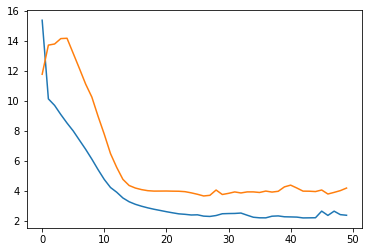

In [112]:
# plot metrics
print(min(history_SimpleModel_1_rotate_5.history['val_rmse']))
plt.plot(history_SimpleModel_1_rotate_5.history['rmse'])
plt.plot(history_SimpleModel_1_rotate_5.history['val_rmse'])
plt.show()

**10 degree**

In [113]:
# transform data
degree = -10
n_point = 8
X_train_model = np.concatenate((X_train_nm, rotate_X(X_train_nm, degree)), axis=0).reshape(-1,96,96,1)
y_train_model = np.concatenate((y_train_nm, rotate_y(y_train_nm, degree, n_point)), axis=0)
# X_val_model = np.concatenate((X_val_nm, rotate_X(X_val_nm, degree)), axis=0).reshape(-1,96,96,1)
# y_val_model = np.concatenate((y_val_nm, rotate_y(y_val_nm, degree, n_point)), axis=0)
X_val_model = X_val_nm.reshape(-1,96,96,1)
y_val_model = y_val_nm

print(X_train_model.shape)
print(y_train_model.shape)
print(X_val_model.shape)
print(y_val_model.shape)

(11206, 96, 96, 1)
(11206, 8)
(1397, 96, 96, 1)
(1397, 8)


In [114]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1_rotate_10 = model.fit(X_train_model, y_train_model, \
                                        epochs=50, shuffle=False, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

Train on 11206 samples, validate on 1397 samples
Epoch 1/50
 - 4s - loss: 213.5409 - rmse: 12.1496 - mean_absolute_error: 9.5716 - mean_absolute_percentage_error: 19.0404 - val_loss: 254.9801 - val_rmse: 15.9306 - val_mean_absolute_error: 12.5667 - val_mean_absolute_percentage_error: 24.6433
Epoch 2/50
 - 3s - loss: 74.9367 - rmse: 8.1019 - mean_absolute_error: 6.1932 - mean_absolute_percentage_error: 12.3972 - val_loss: 165.2094 - val_rmse: 12.8188 - val_mean_absolute_error: 10.1855 - val_mean_absolute_percentage_error: 20.2511
Epoch 3/50
 - 3s - loss: 52.1179 - rmse: 6.8624 - mean_absolute_error: 5.2408 - mean_absolute_percentage_error: 10.5312 - val_loss: 116.2083 - val_rmse: 10.7496 - val_mean_absolute_error: 8.4730 - val_mean_absolute_percentage_error: 16.6621
Epoch 4/50
 - 3s - loss: 36.8239 - rmse: 5.8467 - mean_absolute_error: 4.4661 - mean_absolute_percentage_error: 9.0433 - val_loss: 141.4947 - val_rmse: 11.8777 - val_mean_absolute_error: 10.1515 - val_mean_absolute_percentag

Epoch 36/50
 - 3s - loss: 7.9340 - rmse: 2.7524 - mean_absolute_error: 2.1096 - mean_absolute_percentage_error: 4.3572 - val_loss: 23.1297 - val_rmse: 4.7882 - val_mean_absolute_error: 3.6427 - val_mean_absolute_percentage_error: 7.4838
Epoch 37/50
 - 3s - loss: 6.3720 - rmse: 2.4757 - mean_absolute_error: 1.8878 - mean_absolute_percentage_error: 3.9140 - val_loss: 19.5417 - val_rmse: 4.3945 - val_mean_absolute_error: 3.2116 - val_mean_absolute_percentage_error: 6.8358
Epoch 38/50
 - 3s - loss: 5.7897 - rmse: 2.3579 - mean_absolute_error: 1.7930 - mean_absolute_percentage_error: 3.7268 - val_loss: 19.1302 - val_rmse: 4.3459 - val_mean_absolute_error: 3.1576 - val_mean_absolute_percentage_error: 6.8155
Epoch 39/50
 - 3s - loss: 5.1279 - rmse: 2.2287 - mean_absolute_error: 1.6761 - mean_absolute_percentage_error: 3.4895 - val_loss: 14.8503 - val_rmse: 3.8111 - val_mean_absolute_error: 2.6929 - val_mean_absolute_percentage_error: 5.8977
Epoch 40/50
 - 3s - loss: 5.1184 - rmse: 2.2259 - me

3.588405377026874


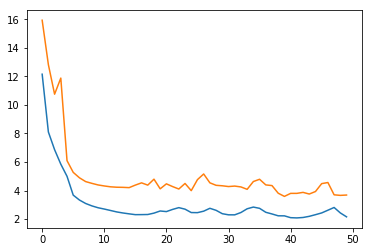

In [115]:
# plot metrics
print(min(history_SimpleModel_1_rotate_10.history['val_rmse']))
plt.plot(history_SimpleModel_1_rotate_10.history['rmse'])
plt.plot(history_SimpleModel_1_rotate_10.history['val_rmse'])
plt.show()

**15 degree**

In [116]:
# transform data
degree = -15
n_point = 8
X_train_model = np.concatenate((X_train_nm, rotate_X(X_train_nm, degree)), axis=0).reshape(-1,96,96,1)
y_train_model = np.concatenate((y_train_nm, rotate_y(y_train_nm, degree, n_point)), axis=0)
# X_val_model = np.concatenate((X_val_nm, rotate_X(X_val_nm, degree)), axis=0).reshape(-1,96,96,1)
# y_val_model = np.concatenate((y_val_nm, rotate_y(y_val_nm, degree, n_point)), axis=0)
X_val_model = X_val_nm.reshape(-1,96,96,1)
y_val_model = y_val_nm

print(X_train_model.shape)
print(y_train_model.shape)
print(X_val_model.shape)
print(y_val_model.shape)

(11206, 96, 96, 1)
(11206, 8)
(1397, 96, 96, 1)
(1397, 8)


In [117]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1_rotate_15 = model.fit(X_train_model, y_train_model, \
                                        epochs=50, shuffle=False, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

Train on 11206 samples, validate on 1397 samples
Epoch 1/50
 - 4s - loss: 170.7227 - rmse: 11.0320 - mean_absolute_error: 8.5661 - mean_absolute_percentage_error: 17.2241 - val_loss: 279.4455 - val_rmse: 16.6802 - val_mean_absolute_error: 13.1934 - val_mean_absolute_percentage_error: 26.0575
Epoch 2/50
 - 3s - loss: 88.7644 - rmse: 8.7897 - mean_absolute_error: 6.7121 - mean_absolute_percentage_error: 13.5820 - val_loss: 241.5355 - val_rmse: 15.5090 - val_mean_absolute_error: 12.3757 - val_mean_absolute_percentage_error: 24.5382
Epoch 3/50
 - 3s - loss: 74.0187 - rmse: 8.0124 - mean_absolute_error: 6.1168 - mean_absolute_percentage_error: 12.3879 - val_loss: 200.0742 - val_rmse: 14.1123 - val_mean_absolute_error: 11.2844 - val_mean_absolute_percentage_error: 22.3762
Epoch 4/50
 - 3s - loss: 60.1206 - rmse: 7.2336 - mean_absolute_error: 5.5144 - mean_absolute_percentage_error: 11.2005 - val_loss: 156.9319 - val_rmse: 12.4960 - val_mean_absolute_error: 9.9758 - val_mean_absolute_percenta

Epoch 36/50
 - 3s - loss: 6.5060 - rmse: 2.5010 - mean_absolute_error: 1.9078 - mean_absolute_percentage_error: 4.0457 - val_loss: 26.1613 - val_rmse: 5.0919 - val_mean_absolute_error: 4.0588 - val_mean_absolute_percentage_error: 9.4111
Epoch 37/50
 - 3s - loss: 7.1182 - rmse: 2.6198 - mean_absolute_error: 2.0202 - mean_absolute_percentage_error: 4.2968 - val_loss: 28.9652 - val_rmse: 5.3629 - val_mean_absolute_error: 4.3017 - val_mean_absolute_percentage_error: 9.9538
Epoch 38/50
 - 3s - loss: 8.7902 - rmse: 2.9101 - mean_absolute_error: 2.2544 - mean_absolute_percentage_error: 4.7402 - val_loss: 36.3817 - val_rmse: 6.0152 - val_mean_absolute_error: 4.8265 - val_mean_absolute_percentage_error: 11.0615
Epoch 39/50
 - 3s - loss: 10.2111 - rmse: 3.1121 - mean_absolute_error: 2.3979 - mean_absolute_percentage_error: 5.0185 - val_loss: 23.0532 - val_rmse: 4.7787 - val_mean_absolute_error: 3.7094 - val_mean_absolute_percentage_error: 8.5912
Epoch 40/50
 - 3s - loss: 7.7754 - rmse: 2.7173 - 

4.210614797637218


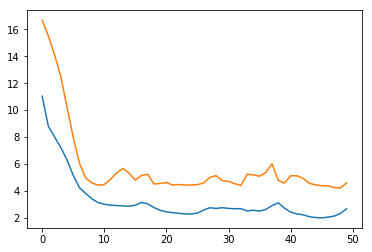

In [118]:
# plot metrics
print(min(history_SimpleModel_1_rotate_15.history['val_rmse']))
plt.plot(history_SimpleModel_1_rotate_15.history['rmse'])
plt.plot(history_SimpleModel_1_rotate_15.history['val_rmse'])
plt.show()

### 3. Test contrast reduction alone

**90 percent**

In [107]:
# transform data
percent = 0.9
X_train_model = np.concatenate((X_train_nm, reduce_contrast(X_train_nm, percent)), axis=0).reshape(-1,96,96,1)
y_train_model = np.concatenate((y_train_nm, y_train_nm), axis=0)
# X_val_model = np.concatenate((X_val_nm, reduce_contrast(X_val_nm, percent)), axis=0).reshape(-1,96,96,1)
# y_val_model = np.concatenate((y_val_nm, y_val_nm), axis=0)
X_val_model = X_val_nm.reshape(-1,96,96,1)
y_val_model = y_val_nm

print(X_train_model.shape)
print(y_train_model.shape)
print(X_val_model.shape)
print(y_val_model.shape)

(11206, 96, 96, 1)
(11206, 8)
(1397, 96, 96, 1)
(1397, 8)


In [108]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1_contrast_90 = model.fit(X_train_model, y_train_model, \
                                        epochs=50, shuffle=False, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

Train on 11206 samples, validate on 1397 samples
Epoch 1/50
 - 4s - loss: 1171.2209 - rmse: 21.6198 - mean_absolute_error: 17.1568 - mean_absolute_percentage_error: 34.3032 - val_loss: 145.1876 - val_rmse: 11.9966 - val_mean_absolute_error: 9.1037 - val_mean_absolute_percentage_error: 18.2673
Epoch 2/50
 - 3s - loss: 117.3428 - rmse: 10.7678 - mean_absolute_error: 8.2261 - mean_absolute_percentage_error: 16.4546 - val_loss: 132.9119 - val_rmse: 11.4811 - val_mean_absolute_error: 8.8751 - val_mean_absolute_percentage_error: 18.1027
Epoch 3/50
 - 3s - loss: 100.8207 - rmse: 9.9840 - mean_absolute_error: 7.6191 - mean_absolute_percentage_error: 15.2667 - val_loss: 121.8590 - val_rmse: 10.9872 - val_mean_absolute_error: 8.4441 - val_mean_absolute_percentage_error: 17.1426
Epoch 4/50
 - 3s - loss: 89.8309 - rmse: 9.4192 - mean_absolute_error: 7.1537 - mean_absolute_percentage_error: 14.3125 - val_loss: 128.1585 - val_rmse: 11.2679 - val_mean_absolute_error: 8.6172 - val_mean_absolute_percen

Epoch 36/50
 - 3s - loss: 8.4524 - rmse: 2.8202 - mean_absolute_error: 2.1155 - mean_absolute_percentage_error: 4.3951 - val_loss: 15.0730 - val_rmse: 3.8277 - val_mean_absolute_error: 2.6741 - val_mean_absolute_percentage_error: 6.0024
Epoch 37/50
 - 3s - loss: 8.8733 - rmse: 2.9010 - mean_absolute_error: 2.2118 - mean_absolute_percentage_error: 4.6101 - val_loss: 19.2612 - val_rmse: 4.3566 - val_mean_absolute_error: 3.2799 - val_mean_absolute_percentage_error: 6.9214
Epoch 38/50
 - 3s - loss: 8.0442 - rmse: 2.7636 - mean_absolute_error: 2.1082 - mean_absolute_percentage_error: 4.4025 - val_loss: 18.5203 - val_rmse: 4.2695 - val_mean_absolute_error: 3.2242 - val_mean_absolute_percentage_error: 6.9272
Epoch 39/50
 - 3s - loss: 6.5811 - rmse: 2.5106 - mean_absolute_error: 1.8851 - mean_absolute_percentage_error: 3.9528 - val_loss: 18.5807 - val_rmse: 4.2758 - val_mean_absolute_error: 3.1954 - val_mean_absolute_percentage_error: 6.8898
Epoch 40/50
 - 3s - loss: 5.6385 - rmse: 2.3315 - me

3.8241325213214545


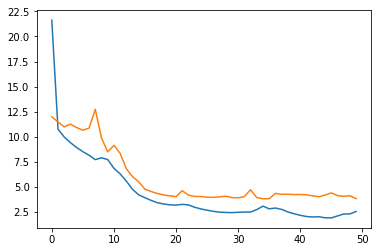

In [109]:
# plot metrics
print(min(history_SimpleModel_1_contrast_90.history['val_rmse']))
plt.plot(history_SimpleModel_1_contrast_90.history['rmse'])
plt.plot(history_SimpleModel_1_contrast_90.history['val_rmse'])
plt.show()

**80 percent**

In [99]:
# transform data
percent = 0.8
X_train_model = np.concatenate((X_train_nm, reduce_contrast(X_train_nm, percent)), axis=0).reshape(-1,96,96,1)
y_train_model = np.concatenate((y_train_nm, y_train_nm), axis=0)
# X_val_model = np.concatenate((X_val_nm, reduce_contrast(X_val_nm, percent)), axis=0).reshape(-1,96,96,1)
# y_val_model = np.concatenate((y_val_nm, y_val_nm), axis=0)
X_val_model = X_val_nm.reshape(-1,96,96,1)
y_val_model = y_val_nm

print(X_train_model.shape)
print(y_train_model.shape)
print(X_val_model.shape)
print(y_val_model.shape)

(11206, 96, 96, 1)
(11206, 8)
(1397, 96, 96, 1)
(1397, 8)


In [102]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1_contrast_80 = model.fit(X_train_model, y_train_model, \
                                        epochs=50, shuffle=False, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

Train on 11206 samples, validate on 1397 samples
Epoch 1/50
 - 4s - loss: 475.2077 - rmse: 14.8403 - mean_absolute_error: 11.7822 - mean_absolute_percentage_error: 23.9073 - val_loss: 146.7171 - val_rmse: 12.0764 - val_mean_absolute_error: 9.3186 - val_mean_absolute_percentage_error: 19.1556
Epoch 2/50
 - 3s - loss: 102.6615 - rmse: 10.0286 - mean_absolute_error: 7.6917 - mean_absolute_percentage_error: 15.3545 - val_loss: 135.2681 - val_rmse: 11.5923 - val_mean_absolute_error: 8.8830 - val_mean_absolute_percentage_error: 18.3673
Epoch 3/50
 - 3s - loss: 85.3371 - rmse: 9.1484 - mean_absolute_error: 6.9759 - mean_absolute_percentage_error: 13.9466 - val_loss: 126.0302 - val_rmse: 11.1797 - val_mean_absolute_error: 8.4938 - val_mean_absolute_percentage_error: 17.5495
Epoch 4/50
 - 3s - loss: 74.1115 - rmse: 8.5239 - mean_absolute_error: 6.4582 - mean_absolute_percentage_error: 12.9266 - val_loss: 115.5433 - val_rmse: 10.6968 - val_mean_absolute_error: 8.0451 - val_mean_absolute_percenta

Epoch 36/50
 - 3s - loss: 4.4003 - rmse: 2.0686 - mean_absolute_error: 1.4903 - mean_absolute_percentage_error: 3.1627 - val_loss: 21.6400 - val_rmse: 4.5933 - val_mean_absolute_error: 3.1704 - val_mean_absolute_percentage_error: 6.7842
Epoch 37/50
 - 3s - loss: 4.2092 - rmse: 2.0195 - mean_absolute_error: 1.4583 - mean_absolute_percentage_error: 3.0887 - val_loss: 21.4128 - val_rmse: 4.5703 - val_mean_absolute_error: 3.1599 - val_mean_absolute_percentage_error: 6.7554
Epoch 38/50
 - 3s - loss: 4.4346 - rmse: 2.0674 - mean_absolute_error: 1.5069 - mean_absolute_percentage_error: 3.1792 - val_loss: 20.0206 - val_rmse: 4.4156 - val_mean_absolute_error: 3.0580 - val_mean_absolute_percentage_error: 6.5427
Epoch 39/50
 - 3s - loss: 5.7184 - rmse: 2.3459 - mean_absolute_error: 1.7612 - mean_absolute_percentage_error: 3.6854 - val_loss: 23.2260 - val_rmse: 4.7598 - val_mean_absolute_error: 3.3373 - val_mean_absolute_percentage_error: 7.2803
Epoch 40/50
 - 3s - loss: 7.1160 - rmse: 2.5953 - me

4.167687917148205


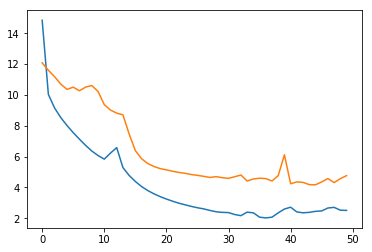

In [103]:
# plot metrics
print(min(history_SimpleModel_1_contrast_80.history['val_rmse']))
plt.plot(history_SimpleModel_1_contrast_80.history['rmse'])
plt.plot(history_SimpleModel_1_contrast_80.history['val_rmse'])
plt.show()

**70 percent**

In [104]:
# transform data
percent = 0.7
X_train_model = np.concatenate((X_train_nm, reduce_contrast(X_train_nm, percent)), axis=0).reshape(-1,96,96,1)
y_train_model = np.concatenate((y_train_nm, y_train_nm), axis=0)
# X_val_model = np.concatenate((X_val_nm, reduce_contrast(X_val_nm, percent)), axis=0).reshape(-1,96,96,1)
# y_val_model = np.concatenate((y_val_nm, y_val_nm), axis=0)
X_val_model = X_val_nm.reshape(-1,96,96,1)
y_val_model = y_val_nm

print(X_train_model.shape)
print(y_train_model.shape)
print(X_val_model.shape)
print(y_val_model.shape)

(11206, 96, 96, 1)
(11206, 8)
(1397, 96, 96, 1)
(1397, 8)


In [105]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1_contrast_70 = model.fit(X_train_model, y_train_model, \
                                        epochs=50, shuffle=False, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

Train on 11206 samples, validate on 1397 samples
Epoch 1/50
 - 4s - loss: 353.1104 - rmse: 15.8972 - mean_absolute_error: 12.8317 - mean_absolute_percentage_error: 25.5167 - val_loss: 194.6360 - val_rmse: 13.8966 - val_mean_absolute_error: 10.7606 - val_mean_absolute_percentage_error: 22.1309
Epoch 2/50
 - 3s - loss: 102.2706 - rmse: 9.9355 - mean_absolute_error: 7.6921 - mean_absolute_percentage_error: 15.3024 - val_loss: 228.3941 - val_rmse: 15.0332 - val_mean_absolute_error: 11.7363 - val_mean_absolute_percentage_error: 24.0733
Epoch 3/50
 - 3s - loss: 98.5715 - rmse: 9.7191 - mean_absolute_error: 7.5662 - mean_absolute_percentage_error: 15.0444 - val_loss: 164.0048 - val_rmse: 12.7273 - val_mean_absolute_error: 9.6688 - val_mean_absolute_percentage_error: 19.6482
Epoch 4/50
 - 3s - loss: 106.6885 - rmse: 10.0867 - mean_absolute_error: 7.9267 - mean_absolute_percentage_error: 15.7277 - val_loss: 185.2214 - val_rmse: 13.4737 - val_mean_absolute_error: 10.1003 - val_mean_absolute_perc

Epoch 35/50
 - 3s - loss: 14.7246 - rmse: 3.6278 - mean_absolute_error: 2.8329 - mean_absolute_percentage_error: 5.7932 - val_loss: 45.5059 - val_rmse: 6.6657 - val_mean_absolute_error: 4.8013 - val_mean_absolute_percentage_error: 10.0997
Epoch 36/50
 - 3s - loss: 9.3607 - rmse: 2.9458 - mean_absolute_error: 2.2673 - mean_absolute_percentage_error: 4.6751 - val_loss: 47.3943 - val_rmse: 6.7983 - val_mean_absolute_error: 4.8721 - val_mean_absolute_percentage_error: 10.1827
Epoch 37/50
 - 3s - loss: 7.5069 - rmse: 2.6592 - mean_absolute_error: 2.0359 - mean_absolute_percentage_error: 4.2061 - val_loss: 48.6905 - val_rmse: 6.8944 - val_mean_absolute_error: 4.9516 - val_mean_absolute_percentage_error: 10.3151
Epoch 38/50
 - 3s - loss: 7.2754 - rmse: 2.6116 - mean_absolute_error: 2.0030 - mean_absolute_percentage_error: 4.1285 - val_loss: 52.2699 - val_rmse: 7.1490 - val_mean_absolute_error: 5.1601 - val_mean_absolute_percentage_error: 10.7266
Epoch 39/50
 - 3s - loss: 8.8962 - rmse: 2.8601

4.133630291427471


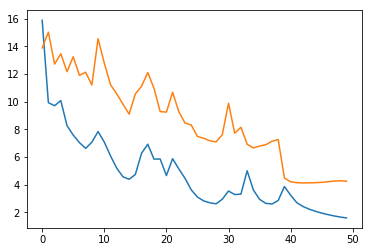

In [106]:
# plot metrics
print(min(history_SimpleModel_1_contrast_70.history['val_rmse']))
plt.plot(history_SimpleModel_1_contrast_70.history['rmse'])
plt.plot(history_SimpleModel_1_contrast_70.history['val_rmse'])
plt.show()

### 4. Test all transformations combined

In [156]:
# transform data
degree1 = -10
degree2 = 10
n_point = 8
percent = 0.9

X_rotated = np.zeros((X_train_nm.shape), dtype=np.float64)
X_rotated[range(0, len(X_train_nm), 2)] = rotate_X(X_train_nm[range(0, len(X_train_nm), 2)], degree1)
X_rotated[range(1, len(X_train_nm), 2)] = rotate_X(X_train_nm[range(1, len(X_train_nm), 2)], degree2)

y_rotated = np.zeros((y_train_nm.shape), dtype=np.float64)
y_rotated[range(0, len(y_train_nm), 2)] = rotate_y(y_train_nm[range(0, len(y_train_nm), 2)], degree1, n_point)
y_rotated[range(1, len(y_train_nm), 2)] = rotate_y(y_train_nm[range(1, len(y_train_nm), 2)], degree2, n_point)   

X_train_model = np.concatenate((X_train_nm, reduce_contrast(X_rotated, percent)), axis=0).reshape(-1,96,96,1)
y_train_model = np.concatenate((y_train_nm, y_rotated), axis=0)
# X_val_model = np.concatenate((X_val_nm, reduce_contrast(rotate_X(mirror_X(X_val_nm), degree), percent)), axis=0).reshape(-1,96,96,1)
# y_val_model = np.concatenate((y_val_nm, rotate_y(mirror_y(y_val_nm, n_point), degree, n_point)), axis=0)
X_val_model = X_val_nm.reshape(-1,96,96,1)
y_val_model = y_val_nm

print(X_train_model.shape)
print(y_train_model.shape)
print(X_val_model.shape)
print(y_val_model.shape)

(11206, 96, 96, 1)
(11206, 8)
(1397, 96, 96, 1)
(1397, 8)


In [157]:
# compile and fit model
model = SimpleModel_1()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse, 'mae', 'mape'])
%time history_SimpleModel_1_trans = model.fit(X_train_model, y_train_model, \
                                        epochs=100, shuffle=False, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

Train on 11206 samples, validate on 1397 samples
Epoch 1/50
 - 5s - loss: 159.0503 - rmse: 11.1798 - mean_absolute_error: 8.7670 - mean_absolute_percentage_error: 17.6583 - val_loss: 255.1291 - val_rmse: 15.9280 - val_mean_absolute_error: 12.5257 - val_mean_absolute_percentage_error: 24.6871
Epoch 2/50
 - 3s - loss: 94.5890 - rmse: 9.0853 - mean_absolute_error: 6.9820 - mean_absolute_percentage_error: 14.0939 - val_loss: 257.8458 - val_rmse: 16.0164 - val_mean_absolute_error: 12.8022 - val_mean_absolute_percentage_error: 25.3090
Epoch 3/50
 - 3s - loss: 82.7357 - rmse: 8.5703 - mean_absolute_error: 6.5531 - mean_absolute_percentage_error: 13.1942 - val_loss: 173.7959 - val_rmse: 13.1419 - val_mean_absolute_error: 10.2771 - val_mean_absolute_percentage_error: 20.7536
Epoch 4/50
 - 3s - loss: 79.1306 - rmse: 8.4420 - mean_absolute_error: 6.5304 - mean_absolute_percentage_error: 13.1675 - val_loss: 240.6091 - val_rmse: 15.4721 - val_mean_absolute_error: 12.6039 - val_mean_absolute_percent

Epoch 35/50
 - 3s - loss: 7.1142 - rmse: 2.6174 - mean_absolute_error: 1.9804 - mean_absolute_percentage_error: 4.1022 - val_loss: 30.0841 - val_rmse: 5.4585 - val_mean_absolute_error: 4.1788 - val_mean_absolute_percentage_error: 8.5970
Epoch 36/50
 - 3s - loss: 6.4972 - rmse: 2.5027 - mean_absolute_error: 1.8832 - mean_absolute_percentage_error: 3.9037 - val_loss: 29.3825 - val_rmse: 5.3937 - val_mean_absolute_error: 4.1036 - val_mean_absolute_percentage_error: 8.4705
Epoch 37/50
 - 3s - loss: 5.7104 - rmse: 2.3492 - mean_absolute_error: 1.7542 - mean_absolute_percentage_error: 3.6552 - val_loss: 27.4427 - val_rmse: 5.2107 - val_mean_absolute_error: 3.9323 - val_mean_absolute_percentage_error: 8.1622
Epoch 38/50
 - 3s - loss: 5.1568 - rmse: 2.2331 - mean_absolute_error: 1.6623 - mean_absolute_percentage_error: 3.4707 - val_loss: 27.6343 - val_rmse: 5.2288 - val_mean_absolute_error: 3.9363 - val_mean_absolute_percentage_error: 8.1814
Epoch 39/50
 - 3s - loss: 4.8973 - rmse: 2.1764 - me

3.9034531084059303


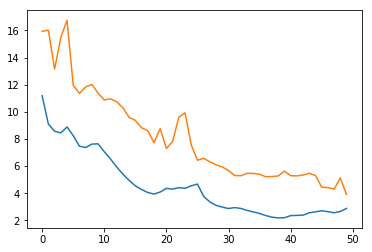

In [158]:
# plot metrics
print(min(history_SimpleModel_1_trans.history['val_rmse']))
plt.plot(history_SimpleModel_1_trans.history['rmse'])
plt.plot(history_SimpleModel_1_trans.history['val_rmse'])
plt.show()

In [159]:
%time history_SimpleModel_1_trans_cont = model.fit(X_train_model, y_train_model, \
                                        epochs=30, shuffle=False, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

Train on 11206 samples, validate on 1397 samples
Epoch 1/30
 - 3s - loss: 7.8469 - rmse: 2.7266 - mean_absolute_error: 2.0758 - mean_absolute_percentage_error: 4.2778 - val_loss: 16.8864 - val_rmse: 4.0646 - val_mean_absolute_error: 2.8760 - val_mean_absolute_percentage_error: 6.2209
Epoch 2/30
 - 3s - loss: 6.2777 - rmse: 2.4570 - mean_absolute_error: 1.8636 - mean_absolute_percentage_error: 3.8773 - val_loss: 16.1716 - val_rmse: 3.9776 - val_mean_absolute_error: 2.8195 - val_mean_absolute_percentage_error: 6.0596
Epoch 3/30
 - 3s - loss: 5.8618 - rmse: 2.3769 - mean_absolute_error: 1.8007 - mean_absolute_percentage_error: 3.7543 - val_loss: 19.7475 - val_rmse: 4.4112 - val_mean_absolute_error: 3.1849 - val_mean_absolute_percentage_error: 6.6361
Epoch 4/30
 - 3s - loss: 5.5279 - rmse: 2.3133 - mean_absolute_error: 1.7501 - mean_absolute_percentage_error: 3.6514 - val_loss: 21.2635 - val_rmse: 4.5821 - val_mean_absolute_error: 3.2779 - val_mean_absolute_percentage_error: 6.7204
Epoch 5

3.670743286908313


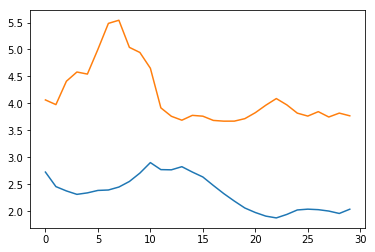

In [160]:
# plot metrics
print(min(history_SimpleModel_1_trans_cont.history['val_rmse']))
plt.plot(history_SimpleModel_1_trans_cont.history['rmse'])
plt.plot(history_SimpleModel_1_trans_cont.history['val_rmse'])
plt.show()

In [161]:
%time history_SimpleModel_1_trans_cont2 = model.fit(X_train_model, y_train_model, \
                                        epochs=30, shuffle=False, batch_size=50, \
                                        validation_data=(X_val_model, y_val_model), \
                                        verbose=2)

Train on 11206 samples, validate on 1397 samples
Epoch 1/30
 - 3s - loss: 5.2838 - rmse: 2.2537 - mean_absolute_error: 1.7241 - mean_absolute_percentage_error: 3.5744 - val_loss: 14.9090 - val_rmse: 3.8008 - val_mean_absolute_error: 2.6156 - val_mean_absolute_percentage_error: 5.8432
Epoch 2/30
 - 3s - loss: 5.6097 - rmse: 2.3080 - mean_absolute_error: 1.7702 - mean_absolute_percentage_error: 3.6883 - val_loss: 14.0250 - val_rmse: 3.6992 - val_mean_absolute_error: 2.6192 - val_mean_absolute_percentage_error: 5.8286
Epoch 3/30
 - 3s - loss: 4.9537 - rmse: 2.1684 - mean_absolute_error: 1.6524 - mean_absolute_percentage_error: 3.4411 - val_loss: 15.1249 - val_rmse: 3.8457 - val_mean_absolute_error: 2.7409 - val_mean_absolute_percentage_error: 5.9814
Epoch 4/30
 - 3s - loss: 4.2576 - rmse: 2.0178 - mean_absolute_error: 1.5314 - mean_absolute_percentage_error: 3.1870 - val_loss: 15.2121 - val_rmse: 3.8574 - val_mean_absolute_error: 2.8130 - val_mean_absolute_percentage_error: 6.2225
Epoch 5

## Test Architectures
### Use random search

In [ ]:
from randomized_relu import randomized_relu
from drop_activation import drop_activation
from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({'randomized_relu': Activation(randomized_relu)})
get_custom_objects().update({'drop_activation': Activation(drop_activation)})

In [11]:
# load data
X = np.load('X.npy')
y = np.load('y.npy')

In [14]:
# prep data
def prep_data(X, y, points):
    
    # model with specific points 
    y_model = y[:, points]

    # get index of non-missing labels
    index = ~np.isnan(y_model).any(axis=1)

    # filter out missing labels on training and validation data
    X_model = X[index]
    y_model = y_model[index]

    # data transformation
    degree1 = -10
    degree2 = 10
    n_point = len(points)
    percent = 0.9

    X_rotated = np.zeros((X_model.shape), dtype=np.float64)
    X_rotated[range(0, len(X_model), 2)] = rotate_X(X_model[range(0, len(X_model), 2)], degree1)
    X_rotated[range(1, len(X_model), 2)] = rotate_X(X_model[range(1, len(X_model), 2)], degree2)

    y_rotated = np.zeros((y_model.shape), dtype=np.float64)
    y_rotated[range(0, len(y_model), 2)] = rotate_y(y_model[range(0, len(y_model), 2)], degree1, n_point)
    y_rotated[range(1, len(y_model), 2)] = rotate_y(y_model[range(1, len(y_model), 2)], degree2, n_point)   

    X_rotated = np.concatenate((X_model, X_rotated), axis=0)
    y_rotated = np.concatenate((y_model, y_rotated), axis=0)
    
    X_contrast = X_rotated.copy()
    X_contrast[range(1, len(X_rotated), 2)] = reduce_contrast(X_rotated[range(1, len(X_rotated), 2)], percent)
    
    return X_contrast.reshape(-1,96,96,1), y_rotated

### Batch 1 - at least 2 and up to 5 conv layers, at least 1 and up to 2 dense layers, optional dropout, 5 activations

In [106]:
# define RMSE
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# create model - use random search - batch 1
def create_model(x_train, y_train, n_point):

    conv_filters_S = [8, 16, 28]
    conv_filters_M = [28, 32, 64]
    conv_filters_L = [64, 96, 128]
    conv_filters_XL = [128, 256, 384]
    add_layer = ['Y', 'N']
    dense_neurons1 = [64, 96, 128, 256]
    dense_neurons2 = [32, 64, 96, 128]
    activations = ['relu', 'LeakyReLU', 'PReLU', 'randomized_relu', 'drop_activation']
    
    activation = choice(activations, p=[0.6, 0.1, 0.1, 0.1, 0.1])
    conv_filter1 = choice(conv_filters_S)
    conv_filter2 = choice(conv_filters_M)
    conv_filter3 = 0
    conv_filter4 = 0
    conv_filter5 = 0
    
    conv_layer_3 = choice(add_layer, p=[0.8, 0.2])
    if conv_layer_3 == 'Y':
        conv_filter3 = choice(conv_filters_L)
        conv_layer_4 = choice(add_layer, p=[0.6, 0.4])
        if conv_layer_4 == 'Y':
            conv_filter4 = choice(conv_filters_L)
            conv_layer_5 = choice(add_layer)
            if conv_layer_5 == 'Y':
                conv_filter5 = choice(conv_filters_XL)
                n_conv_layer = 5
            else:
                n_conv_layer = 4
        else:
            n_conv_layer = 3
    else:
        n_conv_layer = 2
        
    dense_neuron1 = choice(dense_neurons1)
    dense_neuron2 = 0
    dense_layer_2 = choice(add_layer)
    if dense_layer_2 == 'Y':
        dense_neuron2 = choice(dense_neurons2)
        n_dense_layer = 2
    else:
        n_dense_layer = 1
                
    dropout_layer = choice(add_layer, p=[0.05, 0.95])
    if dropout_layer == 'Y':
        dropout_p = uniform(0, 0.5)
    else:
        dropout_p = 0
        
    description = 'ConvLayer-{}-Filter-{}-{}-{}-{}-{}-DenseLayer-{}-Neuron-{}-{}-DropoutLayer-{:.2f}-Activation-{}'.format( \
            n_conv_layer, conv_filter1, conv_filter2, conv_filter3, conv_filter4, conv_filter5, \
            n_dense_layer, dense_neuron1, dense_neuron2, dropout_p, activation)
    
    
    # define model
    model = Sequential()
    
    # conv layer 1
    model.add(Conv2D(conv_filter1, (3, 3), strides=(1,1), padding='same', \
                     input_shape=(96,96,1), data_format='channels_last'))
    model.add(BatchNormalization())
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    
    # conv layer 2
    model.add(Conv2D(conv_filter2, (3, 3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    # optional conv layer 3
    if conv_layer_3 == 'Y':
        model.add(Conv2D(conv_filter3, (3, 3), strides=(1,1), padding='same'))
        model.add(BatchNormalization())
        if activation == 'LeakyReLU':
            model.add(LeakyReLU())
        elif activation == 'PReLU':
            model.add(PReLU())
        else:
            model.add(Activation(activation))
        
        if conv_layer_4 == 'N':
            model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

        # optional conv layer 4
        elif conv_layer_4 == 'Y':
            model.add(Conv2D(conv_filter4, (3, 3), strides=(1,1), padding='same'))
            model.add(BatchNormalization())
            if activation == 'LeakyReLU':
                model.add(LeakyReLU())
            elif activation == 'PReLU':
                model.add(PReLU())
            else:
                model.add(Activation(activation))
            
            if conv_layer_5 =='N':
                model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
            
            # optional conv layer 5
            elif conv_layer_5 == 'Y':
                model.add(Conv2D(conv_filter5, (3, 3), strides=(1,1), padding='same'))
                model.add(BatchNormalization())
                if activation == 'LeakyReLU':
                    model.add(LeakyReLU())
                elif activation == 'PReLU':
                    model.add(PReLU())
                else:
                    model.add(Activation(activation))
                model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    model.add(Flatten())
    
    # fully connected layer 1
    model.add(Dense(dense_neuron1))
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
    
    # optional fully connected layer 2
    if dense_layer_2 == 'Y':
        model.add(Dense(dense_neuron2))
        if activation == 'LeakyReLU':
            model.add(LeakyReLU())
        elif activation == 'PReLU':
            model.add(PReLU())
        else:
            model.add(Activation(activation))
        
    # optional dropout layer before output
    if dropout_layer == 'Y':
        model.add(Dropout(rate=dropout_p))
    
    # output layer
    model.add(Dense(n_point))


    # compile model
    model.compile(loss='mean_squared_error', metrics=[rmse], optimizer='adam')

    return model, description

In [17]:
# create data
X_model1, y_model1 = prep_data(X, y, points = [0, 1, 2, 3, 20, 21, 28, 29])

In [107]:
model, description = create_model(X_model1, y_model1, 8)
print(description)

ConvLayer-3-Filter-8-28-96-0-0-DenseLayer-2-Neuron-128-32-DropoutLayer-0.00-Activation-relu


In [113]:
model_num = []
model_desc = []
model_result = []
model_eval = []

for i in range(200):
    model, description = create_model(X_model1, y_model1, 8)
    print('Model {}: {}'.format(i+1, description))
    
    # fit model
    result = model.fit(X_model1, y_model1, batch_size=64, epochs=20, verbose=0, validation_split=0.1)

    #get the highest validation accuracy of the training epochs
    validation_RMSE = np.amin(result.history['val_rmse'])
    print('Best validation RMSE:', validation_RMSE)
    
    model_num.append(i+1)
    model_desc.append(description)
    model_result.append(result)
    model_eval.append(validation_RMSE)


Model 1: ConvLayer-3-Filter-28-28-64-0-0-DenseLayer-2-Neuron-128-128-DropoutLayer-0.00-Activation-drop_activation
Best validation RMSE: 2.206572147096906
Model 2: ConvLayer-4-Filter-16-28-96-128-0-DenseLayer-1-Neuron-256-0-DropoutLayer-0.00-Activation-randomized_relu
Best validation RMSE: 2.2464510686056953
Model 3: ConvLayer-5-Filter-8-32-128-96-256-DenseLayer-2-Neuron-64-32-DropoutLayer-0.00-Activation-relu
Best validation RMSE: 2.2190891333988736
Model 4: ConvLayer-3-Filter-28-32-128-0-0-DenseLayer-1-Neuron-64-0-DropoutLayer-0.00-Activation-LeakyReLU
Best validation RMSE: 2.5826294817243305
Model 5: ConvLayer-3-Filter-28-28-64-0-0-DenseLayer-1-Neuron-256-0-DropoutLayer-0.00-Activation-relu
Best validation RMSE: 2.457849260057722
Model 6: ConvLayer-5-Filter-28-64-64-64-128-DenseLayer-1-Neuron-128-0-DropoutLayer-0.00-Activation-PReLU
Best validation RMSE: 2.2580609703063965
Model 7: ConvLayer-4-Filter-8-64-128-96-0-DenseLayer-1-Neuron-64-0-DropoutLayer-0.00-Activation-relu
Best valida

Best validation RMSE: 2.3845750386374336
Model 58: ConvLayer-3-Filter-16-28-128-0-0-DenseLayer-2-Neuron-128-64-DropoutLayer-0.00-Activation-LeakyReLU
Best validation RMSE: 2.2814936651502338
Model 59: ConvLayer-5-Filter-8-32-128-64-256-DenseLayer-2-Neuron-64-128-DropoutLayer-0.00-Activation-PReLU
Best validation RMSE: 1.9776926027025494
Model 60: ConvLayer-2-Filter-8-28-0-0-0-DenseLayer-1-Neuron-256-0-DropoutLayer-0.00-Activation-randomized_relu
Best validation RMSE: 2.5874791254316056
Model 61: ConvLayer-3-Filter-16-64-64-0-0-DenseLayer-1-Neuron-256-0-DropoutLayer-0.00-Activation-randomized_relu
Best validation RMSE: 2.231810438973563
Model 62: ConvLayer-5-Filter-8-32-96-64-256-DenseLayer-2-Neuron-128-96-DropoutLayer-0.00-Activation-relu
Best validation RMSE: 2.1485912677219936
Model 63: ConvLayer-3-Filter-16-32-96-0-0-DenseLayer-2-Neuron-96-96-DropoutLayer-0.00-Activation-relu
Best validation RMSE: 2.326189569745745
Model 64: ConvLayer-5-Filter-28-64-64-96-128-DenseLayer-1-Neuron-64-

Best validation RMSE: 2.059187844140189
Model 114: ConvLayer-5-Filter-28-32-96-64-128-DenseLayer-2-Neuron-64-64-DropoutLayer-0.00-Activation-randomized_relu
Best validation RMSE: 2.0894539472035
Model 115: ConvLayer-4-Filter-16-28-128-96-0-DenseLayer-1-Neuron-64-0-DropoutLayer-0.00-Activation-drop_activation
Best validation RMSE: 2.261029564993722
Model 116: ConvLayer-3-Filter-8-32-64-0-0-DenseLayer-1-Neuron-256-0-DropoutLayer-0.00-Activation-randomized_relu
Best validation RMSE: 2.536481956754412
Model 117: ConvLayer-5-Filter-16-32-96-96-256-DenseLayer-1-Neuron-256-0-DropoutLayer-0.00-Activation-relu
Best validation RMSE: 2.072691796166556
Model 118: ConvLayer-5-Filter-16-32-64-128-384-DenseLayer-1-Neuron-96-0-DropoutLayer-0.00-Activation-randomized_relu
Best validation RMSE: 2.405302559988839
Model 119: ConvLayer-5-Filter-28-64-128-128-128-DenseLayer-1-Neuron-128-0-DropoutLayer-0.00-Activation-relu
Best validation RMSE: 2.0294959769930156
Model 120: ConvLayer-4-Filter-28-32-128-96-0-

ResourceExhaustedError: OOM when allocating tensor with shape[64,384,23,23] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_555/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@train...kpropInput"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](activation_615/Relu, conv2d_555/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss_155/mul/_39377}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2260_loss_155/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [116]:
rand_search_output = np.vstack((np.array(model_num), np.array(model_desc), np.array(model_eval))).transpose()
np.save('random_search_output.npy', rand_search_output)
rand_search_output2 = pd.DataFrame(rand_search_output, columns=['Model_Num', 'Description', 'Validation_RMSE']) 

In [121]:
pd.options.display.max_colwidth = 1010
rand_search_output2.sort_values('Validation_RMSE')

,Model_Num,Description,Validation_RMSE
91,92,ConvLayer-5-Filter-8-64-64-96-128-DenseLayer-2-Neuron-96-32-DropoutLayer-0.00-Activation-PReLU,1.955190703528268
24,25,ConvLayer-5-Filter-28-64-64-64-256-DenseLayer-2-Neuron-96-96-DropoutLayer-0.00-Activation-relu,1.9595165484292167
19,20,ConvLayer-5-Filter-8-32-64-128-256-DenseLayer-2-Neuron-96-96-DropoutLayer-0.00-Activation-relu,1.9775424017224994
58,59,ConvLayer-5-Filter-8-32-128-64-256-DenseLayer-2-Neuron-64-128-DropoutLayer-0.00-Activation-PReLU,1.9776926027025494
49,50,ConvLayer-5-Filter-16-32-96-64-128-DenseLayer-1-Neuron-96-0-DropoutLayer-0.00-Activation-relu,1.9957137489318848
124,125,ConvLayer-5-Filter-16-32-64-128-128-DenseLayer-2-Neuron-96-96-DropoutLayer-0.00-Activation-drop_activation,2.0169451904296873
100,101,ConvLayer-5-Filter-16-32-64-64-128-DenseLayer-2-Neuron-64-96-DropoutLayer-0.00-Activation-LeakyReLU,2.026500061580113
118,119,ConvLayer-5-Filter-28-64-128-128-128-DenseLayer-1-Neuron-128-0-DropoutLayer-0.00-Activation-relu,2.0294959769930156
36,37,ConvLayer-4-Filter-28-64-64-64-0-DenseLayer-2-Neuron-256-96-DropoutLayer-0.00-Activation-relu,2.0495268549237933
98,99,ConvLayer-5-Filter-16-32-96-96-256-DenseLayer-2-Neuron-64-32-DropoutLayer-0.00-Activation-relu,2.0522208411352976


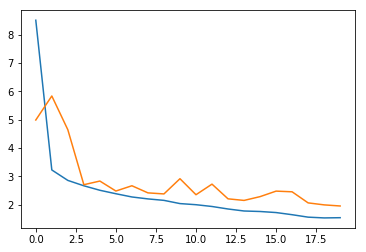

In [125]:
plt.plot(model_result[91].history['rmse'])
plt.plot(model_result[91].history['val_rmse'])
plt.show()

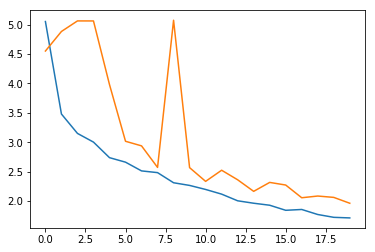

In [127]:
plt.plot(model_result[24].history['rmse'])
plt.plot(model_result[24].history['val_rmse'])
plt.show()

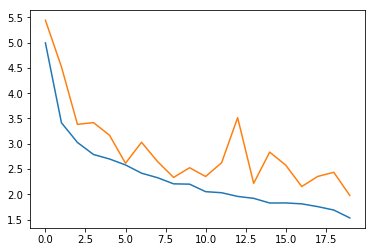

In [128]:
plt.plot(model_result[19].history['rmse'])
plt.plot(model_result[19].history['val_rmse'])
plt.show()

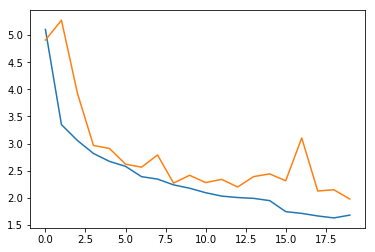

In [129]:
plt.plot(model_result[58].history['rmse'])
plt.plot(model_result[58].history['val_rmse'])
plt.show()

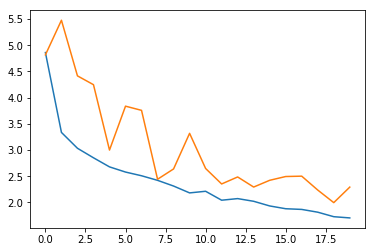

In [130]:
plt.plot(model_result[49].history['rmse'])
plt.plot(model_result[49].history['val_rmse'])
plt.show()

### Batch 2 - Test deeper networks

In [124]:
# define RMSE
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# create model - use random search
def create_model(x_train, y_train, n_point, activation):

    n_conv_layer = 6
    conv_filter1 = 8
    conv_filter2 = 32
    conv_filter3 = 64
    conv_filter4 = 96
    conv_filter5 = 128
    conv_filter6 = 256
    
    n_dense_layer = 3
    dense_neuron1 = 96
    dense_neuron2 = 96
    dense_neuron3 = 32
     
    description = 'ConvLayer-{}-Filter-{}-{}-{}-{}-{}-{}-DenseLayer-{}-Neuron-{}-{}-{}-Activation-{}'.format( \
            n_conv_layer, conv_filter1, conv_filter2, conv_filter3, conv_filter4, conv_filter5, conv_filter6, \
            n_dense_layer, dense_neuron1, dense_neuron2, dense_neuron3, activation)
    
    
    # define model
    model = Sequential()
    
    # conv layer 1
    model.add(Conv2D(conv_filter1, (3, 3), strides=(1,1), padding='same', \
                     input_shape=(96,96,1), data_format='channels_last'))
    model.add(BatchNormalization())
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    
    # conv layer 2
    model.add(Conv2D(conv_filter2, (3, 3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    # conv layer 3
    model.add(Conv2D(conv_filter3, (3, 3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
        
    # conv layer 4
    model.add(Conv2D(conv_filter4, (3, 3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
            
    # conv layer 5
    model.add(Conv2D(conv_filter5, (3, 3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    # conv layer 6
    model.add(Conv2D(conv_filter6, (3, 3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    
    
    model.add(Flatten())
    
    # fully connected layer 1
    model.add(Dense(dense_neuron1))
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
    
    # fully connected layer 2
    model.add(Dense(dense_neuron2))
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))
        
    # fully connected layer 3
    model.add(Dense(dense_neuron3))
    if activation == 'LeakyReLU':
        model.add(LeakyReLU())
    elif activation == 'PReLU':
        model.add(PReLU())
    else:
        model.add(Activation(activation))    
    
    # output layer
    model.add(Dense(n_point))


    # compile model
    model.compile(loss='mean_squared_error', metrics=[rmse], optimizer='adam')

    return model, description

In [136]:
activations = ['relu', 'LeakyReLU', 'PReLU', 'drop_activation']
model_num = []
model_desc = []
model_result = []
model_eval = []
i = 0
    
for activation in activations:
    model, description = create_model(X_model1, y_model1, 8, activation)
    print('Model {}: {}'.format(i, description))

    # fit model
    result = model.fit(X_model1, y_model1, batch_size=64, epochs=20, verbose=0, validation_split=0.1)

    #get the highest validation accuracy of the training epochs
    validation_RMSE = np.amin(result.history['val_rmse'])
    print('Best validation RMSE:', validation_RMSE)

    model_num.append(i)
    model_desc.append(description)
    model_result.append(result)
    model_eval.append(validation_RMSE)
    
    i += 1
    K.clear_session()

Model 0: ConvLayer-6-Filter-8-32-64-96-128-256-DenseLayer-3-Neuron-96-96-32-Activation-relu
Best validation RMSE: 2.2345300483703614
Model 1: ConvLayer-6-Filter-8-32-64-96-128-256-DenseLayer-3-Neuron-96-96-32-Activation-LeakyReLU
Best validation RMSE: 2.0406975167138235
Model 2: ConvLayer-6-Filter-8-32-64-96-128-256-DenseLayer-3-Neuron-96-96-32-Activation-PReLU


ResourceExhaustedError: OOM when allocating tensor with shape[64,128,23,23] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/gradients/zeros_5}} = Fill[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/conv2d_5/BiasAdd_grad/BiasAddGrad"], index_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/Shape_6, training/Adam/gradients/zeros_5/Const)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node metrics/rmse/Mean_1/_459}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3429_metrics/rmse/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [137]:
K.clear_session()

### Test Dropout vs. Batch Normalization

### Test Activation Functions

### Test Locally Connected Layers - after initial architecture selection

### Test Batch Size??

# Scratch Paper

### Random parameter search with Hyperas (Keras wrapper for Hyperopt)

In [22]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

In [57]:
# prep data
def prep_data(X, y, points):
    
    # load data
    # X = np.load('X.npy')
    # y = np.load('y.npy')
    # points = [0, 1, 2, 3, 20, 21, 28, 29]
    
    # model with specific points 
    y_model = y[:, points]

    # get index of non-missing labels
    index = ~np.isnan(y_model).any(axis=1)

    # filter out missing labels on training and validation data
    X_model = X[index]
    y_model = y_model[index]

    # data transformation
    degree1 = -10
    degree2 = 10
    n_point = len(points)
    percent = 0.9

    X_rotated = np.zeros((X_model.shape), dtype=np.float64)
    X_rotated[range(0, len(X_model), 2)] = rotate_X(X_model[range(0, len(X_model), 2)], degree1)
    X_rotated[range(1, len(X_model), 2)] = rotate_X(X_model[range(1, len(X_model), 2)], degree2)

    y_rotated = np.zeros((y_model.shape), dtype=np.float64)
    y_rotated[range(0, len(y_model), 2)] = rotate_y(y_model[range(0, len(y_model), 2)], degree1, n_point)
    y_rotated[range(1, len(y_model), 2)] = rotate_y(y_model[range(1, len(y_model), 2)], degree2, n_point)   

    X_rotated = np.concatenate((X_model, X_rotated), axis=0)
    y_rotated = np.concatenate((y_model, y_rotated), axis=0)
    
    X_contrast = np.zeros((X_rotated.shape), dtype=np.float64)
    X_contrast[range(1, len(X_rotated), 2)] = reduce_contrast(X_rotated[range(1, len(X_rotated), 2)], percent)
    
    return X_contrast.reshape(-1,96,96,1), y_rotated

In [60]:
X_model1, y_model1 = prep_data(X, y, points = [0, 1, 2, 3, 20, 21, 28, 29])
print(X_model1.shape)
print(y_model1.shape)
np.save('X_model1.npy', X_model1)
np.save('y_model1.npy', y_model1)

X_model2, y_model2 = prep_data(X, y, points = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,22,23,24,25,26,27])
print(X_model2.shape)
print(y_model2.shape)
np.save('X_model2.npy', X_model2)
np.save('y_model2.npy', y_model2)

(14000, 96, 96, 1)
(14000, 8)
(4310, 96, 96, 1)
(4310, 22)


In [61]:
def data():
    return np.load('X_model1.npy'), np.load('y_model1.npy')

In [75]:
def model(x_train, y_train, n_point):

    conv_filters = [8, 16, 28, 32, 64, 96, 128]
    
    model = Sequential()
    
    # conv layer 1
    model.add(Conv2D({{choice([8, 16, 28, 32, 64, 96, 128])}}, (3, 3), strides=(1,1), \
                     input_shape=(96,96,1), data_format='channels_last'))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}}))
    
    # conv layer 2
    model.add(Conv2D({{choice([8, 16, 28, 32, 64, 96, 128])}}, (3, 3), strides=(1,1)))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}}))

    # optional conv layer 3
    if {{choice(['two', 'three'])}} == 'three':
        model.add(Conv2D({{choice([8, 16, 28, 32, 64, 96, 128])}}, (3, 3), strides=(1,1)))
        model.add(Activation('relu'))
        model.add(Dropout({{uniform(0, 1)}}))

        # optional conv layer 4
        if {{choice(['three', 'four'])}} == 'four':
            model.add(Conv2D({{choice([8, 16, 28, 32, 64, 96, 128])}}, (3, 3), strides=(1,1)))
            model.add(Activation('relu'))
            model.add(Dropout({{uniform(0, 1)}}))

    model.add(Flatten())
    
    # fully connected layer 1
    model.add(Dense({{choice([32, 64, 96, 128, 256, 512, 1024])}}, activation='relu'))
    model.add(Dropout({{uniform(0, 1)}}))
    
    # optional fully connected layer 2
    if {{choice(['one', 'two'])}} == 'two':
        model.add(Dense({{choice([16, 32, 64, 96, 128, 256])}}, activation='relu'))
        model.add(Dropout({{uniform(0, 1)}}))    
    
    # output layer
    model.add(Dense(n_point))


    # compile model
    model.compile(loss='mean_squared_error', metrics=[rmse], optimizer='adam')

    # fit model
    result = model.fit(x_train, y_train,
              batch_size={{choice([64, 128])}},
              epochs=5,
              verbose=2,
              validation_split=0.1)
    
    #get the highest validation accuracy of the training epochs
    validation_RMSE = np.amin(result.history['val_rmse']) 
    print('Best validation RMSE of epoch:', validation_RMSE)
    return {'Validation RMSE': validation_RMSE, 'status': STATUS_OK, 'model': model}

In [76]:
# define RMSE
#def rmse (y_true, y_pred):
#    return K.sqrt(K.mean(K.square(y_pred - y_true)))

best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      functions=[rmse],
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      trials=Trials(),
                                      notebook_name='data_preprocessing')

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Activation, Flatten
except:
    pass

try:
    from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from scipy.ndimage import rotate
except:
    pass

try:
    from matplotlib import pyplot as plt
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

>>> Hyperas search space:

def get_space():
    return {
        'Conv2D': hp.choice('Conv2D', [8, 16, 28, 32, 64, 96, 128]),
 

NameError: name 'rmse' is not defined

In [ ]:
X_train, Y_train, X_test, Y_test = data(X, y, points = [0, 1, 2, 3, 20, 21, 28, 29])
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)



In [21]:
X_model1.shape

(14000, 96, 96, 1)

In [22]:
y_model1.shape

(14000, 8)

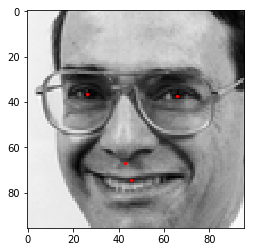

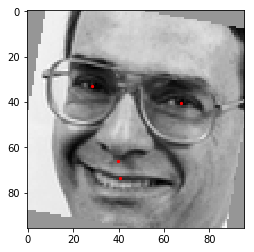

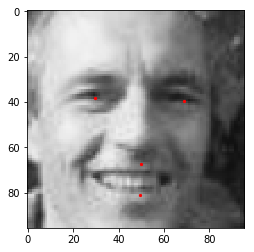

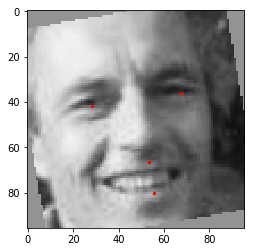

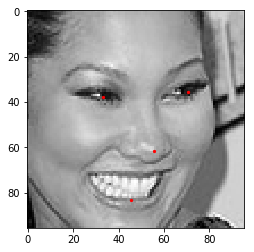

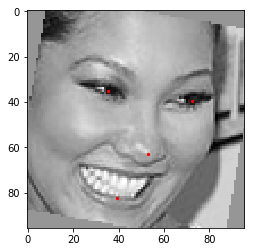

In [24]:
# check image
X_plot = X_model1
y_plot = y_model1

i=0
plt.imshow(X_plot[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_plot[i, range(0, 8, 2)], y_plot[i, range(1, 8, 2)], s=5, color='r')
plt.show()
i=7000
plt.imshow(X_plot[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_plot[i, range(0, 8, 2)], y_plot[i, range(1, 8, 2)], s=5, color='r')
plt.show()

i=1
plt.imshow(X_plot[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_plot[i, range(0, 8, 2)], y_plot[i, range(1, 8, 2)], s=5, color='r')
plt.show()
i=7001
plt.imshow(X_plot[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_plot[i, range(0, 8, 2)], y_plot[i, range(1, 8, 2)], s=5, color='r')
plt.show()

i=2
plt.imshow(X_plot[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_plot[i, range(0, 8, 2)], y_plot[i, range(1, 8, 2)], s=5, color='r')
plt.show()
i=7002
plt.imshow(X_plot[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_plot[i, range(0, 8, 2)], y_plot[i, range(1, 8, 2)], s=5, color='r')
plt.show()

In [520]:
X_train_rotate.max()

343.64848890014355

In [502]:
test = rotate(X_train.reshape(-1,96,96)[3], degree, reshape=False).reshape(96*96)

In [504]:
X_train[3]

array([179., 179., 179., ...,  55.,  57.,  55.])

In [506]:
test.max()

239.34175779242386

In [ ]:
# mirroring
# rotation
# stretching
# shift 
# contrast reduction

In [43]:
~np.isnan(y_train).any(axis=1)[:100]

array([False, False,  True, False, False,  True, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False, False, False,  True, False,  True, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True,  True, False,  True, False, False, False,  True,
       False, False, False, False, False,  True,  True, False, False,
        True, False, False, False, False, False,  True,  True,  True,
       False,  True, False,  True,  True, False, False,  True, False,
       False, False,  True, False,  True, False, False,  True,  True,
        True, False,  True, False, False, False, False,  True, False,
       False])

### test relu, randomized relu, and drop activation

In [65]:
from randomized_relu import randomized_relu
from drop_activation import drop_activation
from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({'randomized_relu': Activation(randomized_relu)})
get_custom_objects().update({'drop_activation': Activation(drop_activation)})

In [66]:
# test relu, randomized relu, and drop activation
def test_relu():
    model = Sequential()
    model.add(Conv2D(8, (5, 5), strides=(1,1), activation='relu', input_shape=(96,96,1), \
                     data_format='channels_last'))
    model.add(Conv2D(4, (3, 3), strides=(1,1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(8))
    
    return model

def test_randomized_relu():
    model = Sequential()
    model.add(Conv2D(8, (5, 5), strides=(1,1), activation='randomized_relu', input_shape=(96,96,1), \
                     data_format='channels_last'))
    model.add(Conv2D(4, (3, 3), strides=(1,1), activation='randomized_relu'))
    model.add(Flatten())
    model.add(Dense(50, activation='randomized_relu'))
    model.add(Dense(8))
    
    return model

def test_drop_activation():
    model = Sequential()
    model.add(Conv2D(8, (5, 5), strides=(1,1), activation='drop_activation', input_shape=(96,96,1), \
                     data_format='channels_last'))
    model.add(Conv2D(4, (3, 3), strides=(1,1), activation='drop_activation'))
    model.add(Flatten())
    model.add(Dense(50, activation='drop_activation'))
    model.add(Dense(8))
    
    return model


In [74]:
model1 = test_relu()
model2 = test_randomized_relu()
model3 = test_drop_activation()
model1.compile(loss='mean_squared_error', metrics=[rmse], optimizer='adam')
model2.compile(loss='mean_squared_error', metrics=[rmse], optimizer='adam')
model3.compile(loss='mean_squared_error', metrics=[rmse], optimizer='adam')

In [75]:
%time result1 = model1.fit(X_model1, y_model1, batch_size=64, epochs=10, verbose=2, validation_split=0.4)

Train on 8400 samples, validate on 5600 samples
Epoch 1/10
 - 3s - loss: 260.7073 - rmse: 14.1122 - val_loss: 111.0243 - val_rmse: 10.4950
Epoch 2/10
 - 2s - loss: 101.0431 - rmse: 10.0011 - val_loss: 68.7175 - val_rmse: 8.2520
Epoch 3/10
 - 2s - loss: 75.0113 - rmse: 8.6185 - val_loss: 99.3739 - val_rmse: 9.9277
Epoch 4/10
 - 2s - loss: 59.5611 - rmse: 7.6730 - val_loss: 47.8289 - val_rmse: 6.8815
Epoch 5/10
 - 2s - loss: 37.7164 - rmse: 6.0951 - val_loss: 28.6372 - val_rmse: 5.3224
Epoch 6/10
 - 2s - loss: 17.0695 - rmse: 4.0837 - val_loss: 19.4909 - val_rmse: 4.3759
Epoch 7/10
 - 2s - loss: 12.0809 - rmse: 3.4407 - val_loss: 17.1811 - val_rmse: 4.1074
Epoch 8/10
 - 2s - loss: 10.5484 - rmse: 3.2044 - val_loss: 16.7008 - val_rmse: 4.0409
Epoch 9/10
 - 2s - loss: 9.4084 - rmse: 3.0179 - val_loss: 15.7146 - val_rmse: 3.9246
Epoch 10/10
 - 2s - loss: 8.3487 - rmse: 2.8439 - val_loss: 15.6424 - val_rmse: 3.9151
Wall time: 26 s


In [72]:
%time result2 = model2.fit(X_model1, y_model1, batch_size=64, epochs=10, verbose=2, validation_split=0.4)

Train on 8400 samples, validate on 5600 samples
Epoch 1/10
 - 3s - loss: 102.5648 - rmse: 10.0887 - val_loss: 67.5372 - val_rmse: 8.1903
Epoch 2/10
 - 3s - loss: 99.6459 - rmse: 9.9407 - val_loss: 74.3012 - val_rmse: 8.5946
Epoch 3/10
 - 3s - loss: 96.8164 - rmse: 9.8017 - val_loss: 66.9642 - val_rmse: 8.1564
Epoch 4/10
 - 3s - loss: 94.6526 - rmse: 9.6810 - val_loss: 103.3209 - val_rmse: 10.1388
Epoch 5/10
 - 3s - loss: 94.1810 - rmse: 9.6646 - val_loss: 71.5321 - val_rmse: 8.4324
Epoch 6/10
 - 3s - loss: 96.0061 - rmse: 9.7426 - val_loss: 62.8203 - val_rmse: 7.9032
Epoch 7/10
 - 3s - loss: 90.3648 - rmse: 9.4611 - val_loss: 77.1100 - val_rmse: 8.7547
Epoch 8/10
 - 3s - loss: 88.9232 - rmse: 9.3935 - val_loss: 97.0575 - val_rmse: 9.8264
Epoch 9/10
 - 3s - loss: 79.7230 - rmse: 8.8871 - val_loss: 58.5163 - val_rmse: 7.6272
Epoch 10/10
 - 3s - loss: 81.1238 - rmse: 8.9491 - val_loss: 54.2037 - val_rmse: 7.3361
Wall time: 28.1 s


In [73]:
%time result3 = model3.fit(X_model1, y_model1, batch_size=64, epochs=10, verbose=2, validation_split=0.4)

Train on 8400 samples, validate on 5600 samples
Epoch 1/10
 - 3s - loss: 109.3603 - rmse: 10.4258 - val_loss: 81.1482 - val_rmse: 8.9797
Epoch 2/10
 - 3s - loss: 107.6781 - rmse: 10.3446 - val_loss: 82.5813 - val_rmse: 9.0575
Epoch 3/10
 - 3s - loss: 105.7454 - rmse: 10.2427 - val_loss: 79.3166 - val_rmse: 8.8772
Epoch 4/10
 - 3s - loss: 104.8285 - rmse: 10.2023 - val_loss: 76.1190 - val_rmse: 8.6971
Epoch 5/10
 - 3s - loss: 101.3723 - rmse: 10.0339 - val_loss: 75.6906 - val_rmse: 8.6729
Epoch 6/10
 - 3s - loss: 101.5123 - rmse: 10.0386 - val_loss: 78.1856 - val_rmse: 8.8142
Epoch 7/10
 - 3s - loss: 101.6332 - rmse: 10.0298 - val_loss: 90.4315 - val_rmse: 9.4843
Epoch 8/10
 - 3s - loss: 97.2844 - rmse: 9.8270 - val_loss: 87.5773 - val_rmse: 9.3311
Epoch 9/10
 - 3s - loss: 95.5099 - rmse: 9.7438 - val_loss: 70.7769 - val_rmse: 8.3845
Epoch 10/10
 - 3s - loss: 99.0571 - rmse: 9.9099 - val_loss: 72.7262 - val_rmse: 8.4982
Wall time: 28 s
